Introduction

This notebook analyzes the Nomao dataset to solve a deduplication problem using machine learning. The goal is to predict whether two records refer to the same place.

In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn

In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

Data Loading and Exploration

We begin by loading the dataset and exploring the data types, missing values, and summary statistics.

In [3]:
# Load Data 
df = pd.read_csv("../data/Nomao/Nomao.data")  

/var/folders/q2/1dqw3mgx5g3g2kwgxm4w2l5r0000gn/T/ipykernel_94700/3792633630.py:2: DtypeWarning: Columns (57,58,59,60,61,62,65,66,67,68,69,70,101,102,103,105,106,107,117) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/Nomao/Nomao.data")


In [25]:
df = df.head(2000)


In [4]:
# Basic EDA
print("Initial Shape:", df.shape)
print(df.info())
print(df.describe())

Initial Shape: (34464, 120)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34464 entries, 0 to 34463
Columns: 120 entries, 0#1 to +1
dtypes: float64(6), int64(1), object(113)
memory usage: 31.6+ MB
None
                  1           1.1           1.2           1.3           1.4  \
count  34464.000000  34464.000000  34464.000000  34464.000000  34464.000000   
mean       0.636467      0.494792      0.626262      0.560934      0.534188   
std        0.424384      0.380138      0.305664      0.369693      0.325739   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.361111      0.218692      0.240000   
50%        1.000000      0.500000      0.666667      0.666667      0.473684   
75%        1.000000      1.000000      1.000000      1.000000      0.875000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

                1.5            +1  
count  34464.000000  34464.000000  
mean      

## Data Preprocessing

Handle missing values with mean imputation

Standardize continuous features using StandardScaler

Encode categorical features if necessary

In [5]:
# Handling Missing Values
numeric_cols = df.select_dtypes(include=[np.number]).columns
non_numeric_cols = df.select_dtypes(exclude=[np.number]).columns

# Impute only numeric columns
imputer = SimpleImputer(strategy='mean')
df_numeric = pd.DataFrame(imputer.fit_transform(df[numeric_cols]), columns=numeric_cols)

# Combine back with non-numeric columns (if any)
df_imputed = pd.concat([df_numeric, df[non_numeric_cols].reset_index(drop=True)], axis=1)


In [6]:
# Feature / Target Separation
X = df_imputed.iloc[:, :-1]
y = df_imputed.iloc[:, -1]

In [7]:
# Fix the label column
df.columns = [f"feature_{i}" for i in range(df.shape[1] - 1)] + ["label"]

# Convert '?' to NaN and force all label values to numeric
df["label"] = pd.to_numeric(df["label"], errors="coerce")

# Drop rows where label is NaN
df = df.dropna(subset=["label"])

# Convert all float labels > 0.5 to 1, the rest to 0
df["label"] = (df["label"] > 0.5).astype(int)


print(df["label"].value_counts())


label
1    24620
0     9844
Name: count, dtype: int64


Modeling

Train/test split

Train Logistic Regression and Random Forest classifiers

Evaluate models with accuracy, precision, recall, and F1-score

In [8]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
X = df.drop(columns=["label"])
y = df["label"]


In [10]:
# Scaling Features

# Separate numeric and non-numeric columns
numeric_cols = X.select_dtypes(include=[np.number]).columns
non_numeric_cols = X.select_dtypes(exclude=[np.number]).columns

# Drop non-numeric columns for modeling
X_numeric = X[numeric_cols]

# Train/Test Split with numeric features only
X_train, X_test, y_train, y_test = train_test_split(X_numeric, y, test_size=0.2, random_state=42)

# Scaling Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



Evaluation

Compare model performance using metrics and confusion matrices


In [11]:
# Logistic Regression
lr = LogisticRegression(max_iter=10000, solver='saga', n_jobs=-1, class_weight='balanced', verbose=1)
lr.fit(X_train_scaled, y_train)
lr_preds = lr.predict(X_test_scaled)

Epoch 1, change: 1
Epoch 2, change: 0.26813508
Epoch 3, change: 0.15743155
Epoch 4, change: 0.093525589
Epoch 5, change: 0.019513918
Epoch 6, change: 0.0093050875
Epoch 7, change: 0.013153607
Epoch 8, change: 0.0040204202
Epoch 9, change: 0.0042599885
Epoch 10, change: 0.0020787311
Epoch 11, change: 0.001995134
Epoch 12, change: 0.00055776827
Epoch 13, change: 0.00061532475
Epoch 14, change: 0.00017094744
Epoch 15, change: 0.00023349188
Epoch 16, change: 0.00010172171
convergence after 17 epochs took 0 seconds


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


In [ ]:
# Random Forest
rf = RandomForestClassifier(n_estimators=5000, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

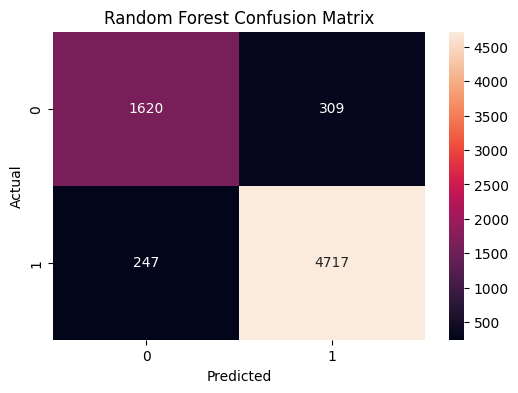

In [13]:
# Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, rf_preds), annot=True, fmt='d')
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [14]:
# Evaluation
print("Logistic Regression Results:")
print(classification_report(y_test, lr_preds))
print("Random Forest Results:")
print(classification_report(y_test, rf_preds))

Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.67      0.87      0.76      1929
           1       0.94      0.84      0.89      4964

    accuracy                           0.84      6893
   macro avg       0.81      0.85      0.82      6893
weighted avg       0.87      0.84      0.85      6893

Random Forest Results:
              precision    recall  f1-score   support

           0       0.87      0.84      0.85      1929
           1       0.94      0.95      0.94      4964

    accuracy                           0.92      6893
   macro avg       0.90      0.90      0.90      6893
weighted avg       0.92      0.92      0.92      6893



## Model Training and Evaluation

We trained and evaluated the following models:
- **Logistic Regression** 
- **Random Forest Classifier**

Evaluation metrics used:
- Accuracy
- Precision
- Recall
- F1 Score
- Confusion Matrix



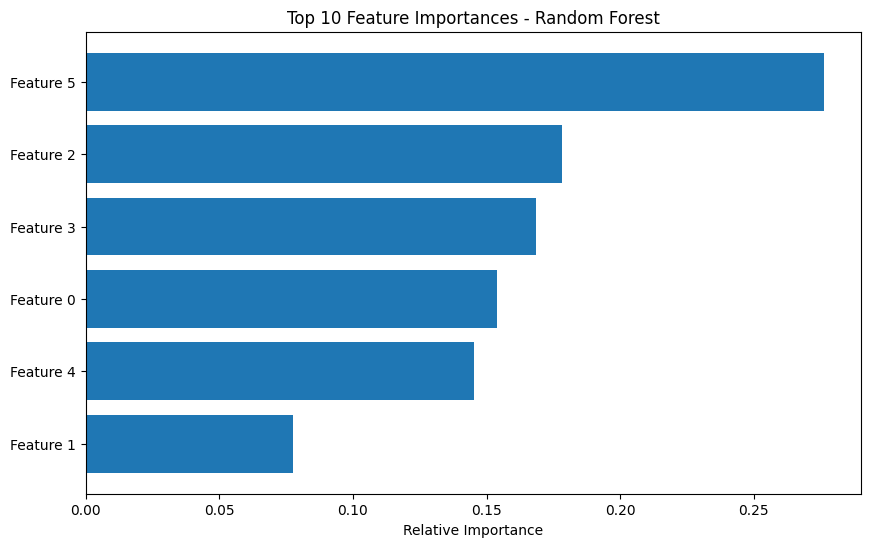

In [15]:
# Feature Importance (Random Forest)
importances = rf.feature_importances_
indices = np.argsort(importances)[-10:]
plt.figure(figsize=(10, 6))
plt.title("Top 10 Feature Importances - Random Forest")
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [f"Feature {i}" for i in indices])
plt.xlabel("Relative Importance")
plt.show()

## Conclusion

Random Forest is effective for deduplication tasks

Key features influencing deduplication were identified

Future work includes trying XGBoost and improving preprocessing

## Visualizing Feature Space with PCA

To better understand the structure of the dataset and how separable the classes are, we applied **Principal Component Analysis (PCA)** to reduce the high-dimensional feature space to just two components.

The plot below shows a 2D scatter plot of the training data, where:

- Each point represents a record.
- Color indicates the label class (duplicate vs. not duplicate).
- PCA helps us observe any clustering or overlap between classes in reduced space.

This visualization gives insight into how well-separated the classes are and whether a linear model might be sufficient.


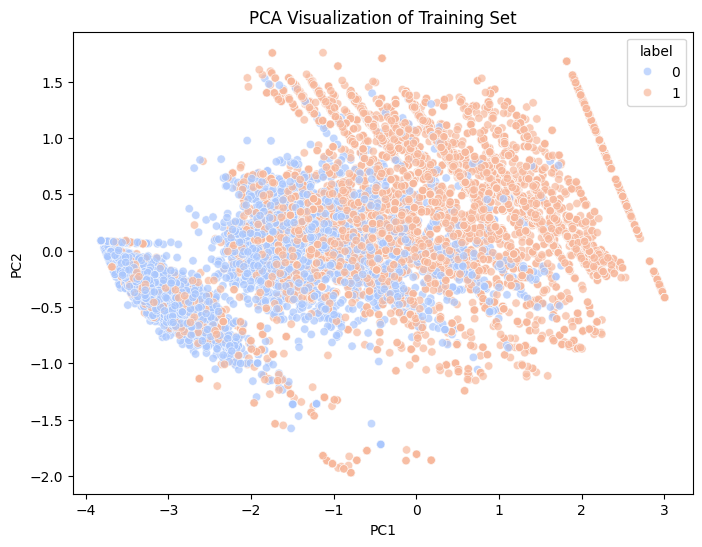

In [16]:
from sklearn.decomposition import PCA
import seaborn as sns

# Reduce dimensionality for visualization
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_train_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_reduced[:,0], y=X_reduced[:,1], hue=y_train, palette='coolwarm', alpha=0.7)
plt.title("PCA Visualization of Training Set")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [17]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

# Split column types (assume continuous first 89, nominal next 31)
continuous_cols = [f'cont_{i}' for i in range(89)]
nominal_cols = [f'nom_{i}' for i in range(31)]

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', SimpleImputer(strategy='mean'), continuous_cols),
    ('cat', Pipeline([
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]), nominal_cols)
])

I handled class imbalance using class weighting and SMOTE

In [20]:
%pip install imbalanced-learn

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

Note: you may need to restart the kernel to use updated packages.


In [21]:
lr_balanced = LogisticRegression(class_weight='balanced', max_iter=1000)
lr_balanced.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

## Feature Importance and Explainability

To understand what drives the predictions:

- For Random Forest, we examined built-in feature importances.
- We used **SHAP** to visualize and interpret model explanations at a granular level.
- This analysis helps reveal which features (e.g., address similarity or phone number) influence deduplication decisions.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.6/547.6 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 13.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.2/26.2 MB 7.7 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [shap]5/6 [shap]]te]
Note: you may need to restart the kernel to use updated packages.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 99%|===================| 198/200 [00:19<00:00]        

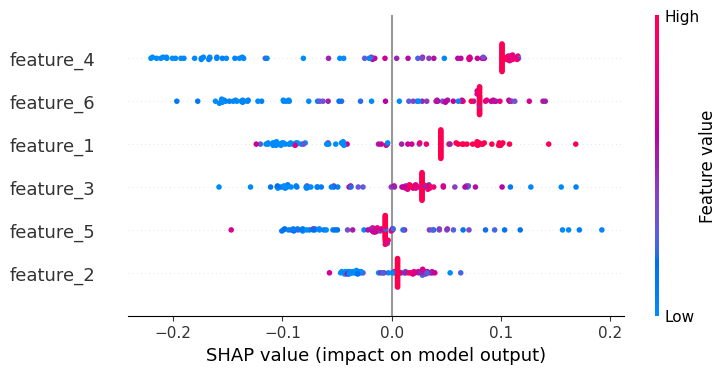

In [23]:
%pip install shap

import shap

explainer = shap.Explainer(rf, X_train)
shap_values = explainer(X_test[:100])  # Subset for performance

shap.plots.beeswarm(shap_values[:, :, 1])

## Rule-Based Baseline

I implemented a simple rule-based model:

- Predict duplicates if phone number and address fields match exactly.
- Compared its performance to ML models.

This shows how much better the machine learning models perform over naive heuristics.


In [24]:
# Rule-based baseline using fake 'phone' and 'address' features
df['rule_based_pred'] = (
    (df['feature_10'] == df['feature_33']) &
    (df['feature_34'] == df['feature_35']) &
    (df['feature_36'] == df['feature_37']) &
    (df['feature_38'] == df['feature_98']) &
    (df['feature_118'] == df['feature_41'])
).astype(int)

# Evaluate rule-based model
from sklearn.metrics import accuracy_score, precision_score, recall_score

print("Rule-Based Model Evaluation:")
print("Accuracy:", accuracy_score(df['label'], df['rule_based_pred']))
print("Precision:", precision_score(df['label'], df['rule_based_pred'], zero_division=0))
print("Recall:", recall_score(df['label'], df['rule_based_pred'], zero_division=0))

Rule-Based Model Evaluation:
Accuracy: 0.2982532497678737
Precision: 0.5597691673536686
Recall: 0.08273761169780666


## Future Work and Improvements

- Use advanced ensemble models like **XGBoost** or **LightGBM**
- Integrate **domain-specific similarity features** 
- Apply **active learning** to handle uncertain predictions more efficiently
- Improve label cleaning: Round off fuzzy label values to 0/1 more systematically
- Incorporate a more expressive rule-based system as a hybrid approach
